
## 1. Parameters & Imports

In [ ]:

repo_id     = "joseph-tennyson/poisson-0.32"   
ckpt_name   = "state.pt"              
loss_type   = "poisson"            
n_tasks     = 10000
n_train     = 40                          
lr          = 0.05
max_steps   = 100000
tol         = 1e-10

# can be loaded in from config or set to defaults 
# especially useful if you want to mix and match train/eval function types 
r_val = 5.0
scale = 0.32

# — Standard imports —
import os, sys, yaml
import torch
from torch.nn import PoissonNLLLoss
import matplotlib.pyplot as plt

# Make plots inline
%matplotlib inline

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


## 2. Download HF Repo & Load Config

In [4]:
# if you don't already have huggingface_hub installed:
!pip install -q huggingface_hub

from huggingface_hub import snapshot_download
from types import SimpleNamespace

# download into a local folder
ckpt_dir = snapshot_download(repo_id, repo_type="model")
print("Repo downloaded to:", ckpt_dir)

sys.path.append(ckpt_dir)

cfg = yaml.safe_load(open(os.path.join(ckpt_dir, "config.yaml")))
print("Config keys:", cfg.keys())

model_conf = SimpleNamespace(**cfg["model"])
task_kwargs = cfg["training"]["task_kwargs"]
scale = task_kwargs.get("scaling", 1.0)
r_val = task_kwargs.get("r", None) or r_val
n_train = cfg["model"]["n_positions"]

print(f"n_dims={model_conf.n_dims}, scale={scale}, r={r_val}")

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Repo downloaded to: /home/joseph_tennyson/.cache/huggingface/hub/models--joseph-tennyson--poisson-0.32/snapshots/e5dea11891532d77f2f70027336eeb794356b00b
Config keys: dict_keys(['config', 'model', 'out_dir', 'test_run', 'training', 'wandb'])
n_dims=10, scale=0.32, r=5.0


## 3. Sampling & Loss Registry

In [5]:
def sample_data(n_tasks, n_points, d, ws=None, scale=1.0, loss_type="poisson", r=None):
    xs = torch.randn(n_tasks, n_points, d, device=device)
    if ws is None:
        ws = scale * torch.randn(n_tasks, d, 1, device=device)
    logits = (xs @ ws).clamp(-4, 4)    # shape: [n_tasks, n_points, 1]
    mu = torch.exp(logits)

    if loss_type == "poisson":
        ys = torch.poisson(mu).squeeze(-1)
    elif loss_type in ("nb", "neg_binomial"):
        r_t = torch.tensor(r, device=device, dtype=mu.dtype)
        probs = r_t / (r_t + mu)
        dist = torch.distributions.NegativeBinomial(total_count=r_t, probs=probs)
        ys = dist.sample().squeeze(-1)
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")
    return xs, ys, ws

# registry for your model's NLL
LOSS_REGISTRY = {}
def register_loss(name):
    def deco(fn):
        LOSS_REGISTRY[name] = fn
        return fn
    return deco

@register_loss("poisson")
def poisson_loss_fn(pred, targets, **kw):
    return PoissonNLLLoss(log_input=True, full=True, reduction="none")(pred, targets)

@register_loss("nb")
def nb_loss_fn(preds, targets, r, **kw):
    mu = torch.exp(preds)
    r_t = torch.tensor(r, device=mu.device, dtype=mu.dtype)
    probs = r_t / (r_t + mu)
    dist = torch.distributions.NegativeBinomial(total_count=r_t, probs=probs)
    return -dist.log_prob(targets)

## 4. Evaluation Routines

In [23]:
from tqdm import tqdm
loss_fn = LOSS_REGISTRY[loss_type]

def get_logits(xs, ws):
    logits = (xs @ ws).squeeze(-1).clamp(-4, 4)
    return logits

# 4.1 Transformer evaluation
def evaluate_transformer(model, xs_all, ys_all, loss_type="poisson", r=None):
    model.eval()
    with torch.no_grad():
        out = model(xs_all, ys_all)   
        per_pos = loss_fn(out, ys_all, r=r).mean(dim=0)
    return per_pos.cpu().tolist()

# 4.2 Gradient‑descent oracle (re-fit per context length)
def evaluate_oracle_gd(xs_all, ys_all, lr, max_steps, tol, scale=1.0, r=None, loss_type="poisson"):
    n_tasks, n_points, d = xs_all.shape
    all_losses = []
    loss_fn = LOSS_REGISTRY[loss_type]
    for t in tqdm(range(1, n_points), desc="GD Oracle"):
        xs_tr = xs_all[:, :t, :]
        ys_tr = ys_all[:, :t]
        xs_te = xs_all[:, t:t+1, :]
        ys_te = ys_all[:, t:t+1]

        w_hat = torch.randn(n_tasks, d, 1, device=device, requires_grad=True)
        opt = torch.optim.Adam([w_hat], lr=lr)
        prev = float("inf")
        for step in range(max_steps):
            logits = get_logits(xs_tr, w_hat)
            loss = loss_fn(logits, ys_tr, r=r).mean()
            loss = loss + (0.5/scale**2)*w_hat.pow(2).sum()/(n_tasks*t)
            if abs(prev - loss.item()) < tol:
                break
            prev = loss.item()
            opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            logits_te = get_logits(xs_te, w_hat)
            loss_te = loss_fn(logits_te, ys_te, r=r).mean().item()
        all_losses.append(loss_te)
    return all_losses

# 4.3 True‑weights oracle
def evaluate_oracle_true(xs_all, ys_all, ws, loss_type="poisson", r=None):
    n_tasks, n_points, _ = xs_all.shape
    losses = []
    for t in range(1, n_points):
        x_te = xs_all[:, t:t+1, :]
        y_te = ys_all[:, t:t+1]
        logits = get_logits(x_te, ws)
        loss = loss_fn(logits, y_te, r=r).mean()
        losses.append(loss.item())
    return losses

# 4.4 Naive‑mean baseline
def evaluate_naive(ys_all):
    _, n_points = ys_all.shape
    losses = []
    for t in range(1, n_points):
        y_tr = ys_all[:, :t]
        y_te = ys_all[:, t:t+1]
        pred = y_tr.mean(dim=1, keepdim=True)
        # loss_func expects log input 
        loss = loss_fn(torch.log(pred), y_te).mean().item()
        losses.append(loss)
    return losses

## 5. Sample Data & Load Model

In [7]:
xs_all, ys_all, ws_true = sample_data(
    n_tasks,
    n_train,
    model_conf.n_dims,
    scale=scale,
    loss_type=loss_type,
    r=r_val
)
xs_all, ys_all = xs_all.to(device), ys_all.to(device)

from models import build_model

ckpt_path = os.path.join(ckpt_dir, ckpt_name)
state = torch.load(ckpt_path, map_location=device)
model = build_model(model_conf).to(device)
print("Loading", ckpt_name)
model.load_state_dict(state.get("model_state_dict", state))

print("Running transformer...")
trans_losses = evaluate_transformer(model, xs_all, ys_all, loss_type, r_val)

Loading state.pt
Running transformer...


## 6. Run Baselines & GD‑Oracle

In [24]:
# print("Running GD‑oracle…")
# gd_losses    = evaluate_oracle_gd(
#     xs_all, ys_all, lr, max_steps, tol,
#     scale=scale, r=r_val, loss_type=loss_type
# )

# print("Running true‑weights oracle…")
# true_losses  = evaluate_oracle_true(xs_all, ys_all, ws_true, loss_type, r_val)

print("Running naive baseline…")
naive_losses = evaluate_naive(ys_all.cpu())

Running naive baseline…


## 7. Plot All Results

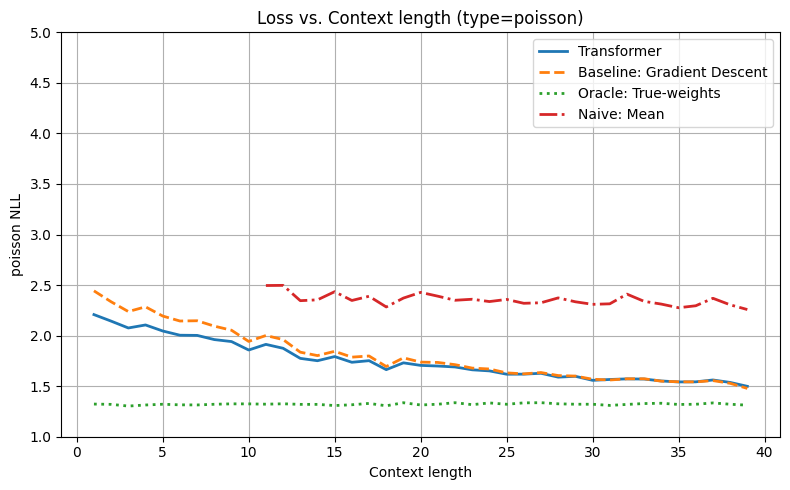

In [25]:
x_label = "Context length"
y_label = f"{loss_type} Loss"
title = f"Loss vs. Context length (type={loss_type})"

ctx = list(range(1, n_train))
plt.figure(figsize=(8,5))
plt.plot(ctx, trans_losses[1:], label="Transformer", linewidth=2)
plt.plot(ctx, gd_losses,    label="Baseline: Gradient Descent", linestyle="--", linewidth=2)
plt.plot(ctx, true_losses,  label="Oracle: True‑weights", linestyle=":", linewidth=2)
plt.plot(ctx, naive_losses, label="Naive: Mean", linestyle="-.", linewidth=2)

plt.xlabel("Context length")
plt.ylabel(f"{loss_type} NLL")
plt.title(f"Loss vs. Context length (type={loss_type})")
plt.legend(loc="upper right")
plt.ylim(1.0, 5)
plt.grid(True)
plt.tight_layout()
plt.show()